# Stan Examples

I want to get stan working. 

## Installation

tbc


In [1]:
import stan

import nest_asyncio
nest_asyncio.apply()  
# Allows nested event loops so that we can run tasks
# in Jupyter notebooks while the event loop is running

# schools_code = """
# data {
#   int<lower=0> J;         // number of schools
#   real y[J];              // estimated treatment effects
#   real<lower=0> sigma[J]; // standard error of effect estimates
# }
# parameters {
#   real mu;                // population treatment effect
#   real<lower=0> tau;      // standard deviation in treatment effects
#   vector[J] eta;          // unscaled deviation from mu by school
# }
# transformed parameters {
#   vector[J] theta = mu + tau * eta;        // school treatment effects
# }
# model {
#   target += normal_lpdf(eta | 0, 1);       // prior log-density
#   target += normal_lpdf(y | theta, sigma); // log-likelihood
# }
# """

with open("schools.stan") as f:
  schools_code = f.read()

In [2]:
schools_data = {"J": 8,
                "y": [28,  8, -3,  7, -1,  1, 18, 12],
                "sigma": [15, 10, 16, 11,  9, 11, 10, 18]}

In [3]:
posterior = stan.build(schools_code, data=schools_data, random_seed=1)


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_g32ch6p6/model_gbn5vn2y.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_g32ch6p6/model_gbn5vn2y.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [4]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!


In [5]:
eta = fit["eta"]  # array with shape (8, 4000)
df = fit.to_frame()
print(df.describe().T)

                count       mean       std            min        25%  \
parameters                                                             
lp__           4000.0 -39.558364  2.640910  -5.022812e+01 -41.190495   
accept_stat__  4000.0   0.837646  0.231352  9.238959e-285   0.796451   
stepsize__     4000.0   0.382061  0.048842   3.189488e-01   0.360265   
treedepth__    4000.0   3.216750  0.527578   1.000000e+00   3.000000   
n_leapfrog__   4000.0  10.238500  4.222982   1.000000e+00   7.000000   
divergent__    4000.0   0.001000  0.031611   0.000000e+00   0.000000   
energy__       4000.0  44.540499  3.422487   3.460108e+01  42.107246   
mu             4000.0   8.313130  5.403206  -8.820034e+00   5.027539   
tau            4000.0   6.756199  5.970169   4.333026e-04   2.419978   
eta.1          4000.0   0.393585  0.956854  -3.154297e+00  -0.252585   
eta.2          4000.0  -0.019616  0.867496  -3.265697e+00  -0.584222   
eta.3          4000.0  -0.212549  0.911758  -3.381211e+00  -0.84

## Covid Timeseries Example

Based on the deterministic reporting (fixed bias) model, initially with a known R value

### Data Generation

In [2]:
import datetime
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'

from periodic_sampling.synthetic_data import RenewalModel, Reporter

100%|██████████| 100/100 [00:00<00:00, 151037.23it/s]


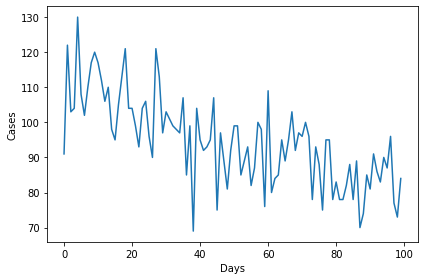

In [3]:
# Simulate Renewal Model
time_steps = 100; N_0 = 100; seed=41; R0 = 0.99
start_date = '01/01/2020'; bias_method = 'scale'

bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first

np.random.seed(seed)
model = RenewalModel()
model.simulate(T=time_steps, N_0=N_0, R_0=0.99)
model.plot()

In [4]:
# Report unbiased and biased data
rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease

truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

### Inference Framework

In [5]:
import os

class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).
    Credit to randlet (https://github.com/facebook/prophet/issues/223).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

In [15]:
with open("fixed_bias_example.stan") as f:
    fixed_bias_code = f.read()

c_val = list(bias_df['Confirmed'])

fixed_bias_data = {
    "time_steps": len(c_val),
    "C": c_val,
    "R": 0.99,
    "serial_interval": RenewalModel(R0=None).serial_interval,
}
with suppress_stdout_stderr():
    posterior = stan.build(fixed_bias_code, data=fixed_bias_data, random_seed=2) 

Building...



Building: 33.8s, done.

In [ ]:
# posterior = stan.build(fixed_bias_code, data=fixed_bias_data, random_seed=1)

In [16]:
bias_init_val = [1.0 for x in range(7)]
chain_num = 1
init_values = [{'alpha': bias_init_val} for _ in range(chain_num)]  # List of dict for each chain

fit = posterior.sample(num_chains=chain_num, num_samples=4)#, init=init_values)

Sampling:   0%
Sampling: 100% (1004/1004)
Sampling: 100% (1004/1004), done.
Messages received during sampling:
  591.555
92

  591.555
92

  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!
  591.555
92

  0
92

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/tmp/httpstan_3tgnh_47/model_tum4m2oo.stan', line 44, column 4 to column 23)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  591.555
92

  0
92

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_l

In [10]:
df = fit.to_frame()
print(df.describe().T)

               count          mean       std           min           25%  \
parameters                                                                 
lp__             4.0  33934.140094  1.010221  33932.704808  33933.845173   
accept_stat__    4.0      0.896261  0.048206      0.838335      0.867021   
stepsize__       4.0      0.739835  0.000000      0.739835      0.739835   
treedepth__      4.0      3.000000  0.000000      3.000000      3.000000   
n_leapfrog__     4.0      7.000000  0.000000      7.000000      7.000000   
divergent__      4.0      0.000000  0.000000      0.000000      0.000000   
energy__         4.0 -33931.091032  1.497787 -33932.109792 -33932.082988   
alpha.1          4.0      1.011517  0.024102      0.986435      0.993292   
alpha.2          4.0      1.010059  0.018492      0.990855      0.996392   
alpha.3          4.0      1.004252  0.029812      0.965120      0.988992   
alpha.4          4.0      1.017189  0.020821      1.000656      1.000773   
alpha.5     